In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Rescaling, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetV2S
import matplotlib.pyplot as plt

2024-11-20 15:06:36.874966: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 15:06:37.160035: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732089997.261941     411 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732089997.290748     411 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 15:06:37.545316: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(gpu)
    print("\nTensorFlow is using the following GPU(s):")
    print(tf.config.experimental.get_visible_devices('GPU'))
else:
    print("No GPUs found. TensorFlow is running on CPU.")

GPUs available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

TensorFlow is using the following GPU(s):
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
!nvidia-smi

Wed Nov 20 15:06:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.41                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P0             13W /   88W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
train_dir = "/mnt/c/Capstone Project/Model/Database/Kulkas/Train"
val_dir = "/mnt/c/Capstone Project/Model/Database/Kulkas/CV"
test_dir = "/mnt/c/Capstone Project/Model/Database/Kulkas/Test"

train_datagen = ImageDataGenerator(
    # rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(
    # rescale = 1/255.,
)

test_datagen = ImageDataGenerator(
    # rescale = 1/255.,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 79427 images belonging to 70 classes.
Found 26617 images belonging to 70 classes.
Found 33464 images belonging to 70 classes.


In [14]:
Efficientnet = EfficientNetV2S(

    include_top=False,

    weights='imagenet',

    input_shape = (256,256,3)

)

In [15]:
for layer in Efficientnet.layers:

    layer.trainable= False

In [16]:
Efficientnet.summary()

Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        648 │ rescaling_1[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 128, 128,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 128, 128,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 128, 128,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 128, 128,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 128, 128,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,331,360 (77.56 MB)

In [17]:
last_layer = Efficientnet.get_layer('block6o_add')

last_output = last_layer.output

In [18]:
x = tf.keras.layers.Conv2D(256, (3,3),activation ='relu')(last_output)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(70, activation='sigmoid')(x)

model = tf.keras.Model(Efficientnet.input, x)

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        648 │ rescaling_1[0][0] │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 128, 128,  │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 128, 128,  │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 128, 128,  │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 128, 128,  │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 128, 128,  │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │          0 │ block2a_expand_b

 Total params: 20,756,134 (79.18 MB)

 Trainable params: 757,574 (2.89 MB)

 Non-trainable params: 19,998,560 (76.29 MB)

In [19]:
if tf.config.list_physical_devices('GPU'):
    print ("Pakai GPU")
else:
    print("Pake CPU")

Pakai GPU


In [20]:
history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10)

/home/nicholas_tanugroho/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1732090107.930551     578 service.cc:148] XLA service 0x7f8e840a0080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732090107.931321     578 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-20 15:08:28.610578: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732090110.277108     578 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-20 15:08:33.485690: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_15877_0', 8 bytes spill stores, 8 bytes spill loads

2024-11-20 15:08:34.999997: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_245

2483/2483 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.4837 - loss: 0.1460

2024-11-20 15:30:14.870645: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4243', 16 bytes spill stores, 16 bytes spill loads

2024-11-20 15:34:44.280502: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4236', 4 bytes spill stores, 4 bytes spill loads

2024-11-20 15:34:44.892661: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4243', 24 bytes spill stores, 24 bytes spill loads



2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1597s 628ms/step - accuracy: 0.4837 - loss: 0.1460 - val_accuracy: 0.6680 - val_loss: 0.0370
Epoch 2/10
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1462s 589ms/step - accuracy: 0.7786 - loss: 0.0248 - val_accuracy: 0.6763 - val_loss: 0.0358
Epoch 3/10
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1474s 593ms/step - accuracy: 0.8159 - loss: 0.0215 - val_accuracy: 0.7130 - val_loss: 0.0362
Epoch 4/10
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1372s 552ms/step - accuracy: 0.8309 - loss: 0.0204 - val_accuracy: 0.7117 - val_loss: 0.0363
Epoch 5/10
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1374s 553ms/step - accuracy: 0.8466 - loss: 0.0194 - val_accuracy: 0.7324 - val_loss: 0.0355
Epoch 6/10
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1472s 593ms/step - accuracy: 0.8525 - loss: 0.0189 - val_accuracy: 0.7212 - val_loss: 0.0366
Epoch 7/10
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1368s 551ms/step - accuracy: 0.8590 - loss: 0.0185 - val_accuracy: 0.7260 - val_loss: 0.0390
Epoch 8/10
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1384s 557ms/step - accur

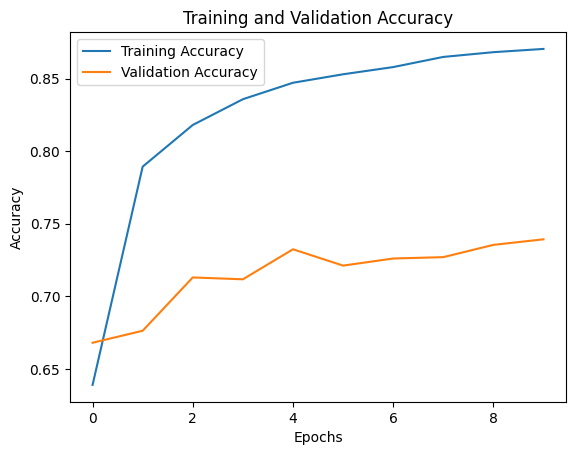

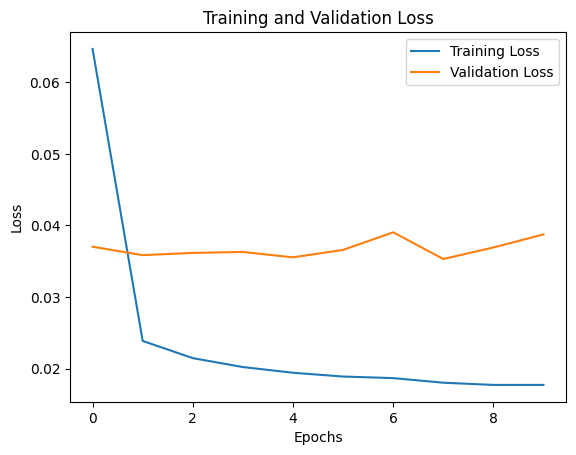

In [23]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
val_loss, val_acc = model.evaluate(val_generator)
tra_loss, tra_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Train Accuracy\t\t: {tra_acc * 100:.2f}% | Train Loss\t\t: {tra_loss}")
print(f"Validation Accuracy\t: {val_acc * 100:.2f}% | Validation Loss\t: {val_loss}")
print(f"Test Accuracy\t\t: {test_acc * 100:.2f}% | Test Loss \t\t: {test_loss}")

832/832 ━━━━━━━━━━━━━━━━━━━━ 296s 355ms/step - accuracy: 0.7411 - loss: 0.0385
2483/2483 ━━━━━━━━━━━━━━━━━━━━ 1358s 547ms/step - accuracy: 0.8986 - loss: 0.0145
1045/1046 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7026 - loss: 0.0431

2024-11-20 19:57:04.386246: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4236', 4 bytes spill stores, 4 bytes spill loads

2024-11-20 19:57:04.927006: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4243', 24 bytes spill stores, 24 bytes spill loads



1046/1046 ━━━━━━━━━━━━━━━━━━━━ 389s 372ms/step - accuracy: 0.7026 - loss: 0.0431
Train Accuracy		: 90.00% | Train Loss		: 0.014427639544010162
Validation Accuracy	: 73.93% | Validation Loss	: 0.03874412924051285
Test Accuracy		: 70.14% | Test Loss 		: 0.04385356232523918


In [25]:
model.save(r"../Deployed/food_recognition_model_EffNet_BLMOPT_multiclass_("+str(test_acc*100)+"%).h5")

In [26]:
model.save(r"../Deployed/food_recognition_model_EffNet_BLMOPT_multiclass_("+str(test_acc*100)+"%).keras")